<a href="https://colab.research.google.com/github/vggls/Time_Series_Prediction/blob/master/ARIMA_and_LSTM_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [ ]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') # useful for time series

from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

## Import data

In [ ]:
train = pd.read_csv("/content/DailyDelhiClimateTrain.csv",
                    index_col = "date", parse_dates = True)

test = pd.read_csv("/content/DailyDelhiClimateTest.csv",
                    index_col = "date", parse_dates = True)

train.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
print(f"Train shape : {train.shape}\nTest shape : {test.shape}\n")
train.info()
test.info()

Train shape : (1462, 4)
Test shape : (114, 4)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2017-01-01 to 2017-04-24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      114 non-null    float64
 1   humidity      114 non-null    float64
 2   wind_speed    114 non-null    float64
 3   meanpressure  114 non-null    float64
dtypes: float64(4)
memory usage: 4.5 KB


There are no missing values.

## EDA: Feature visualization

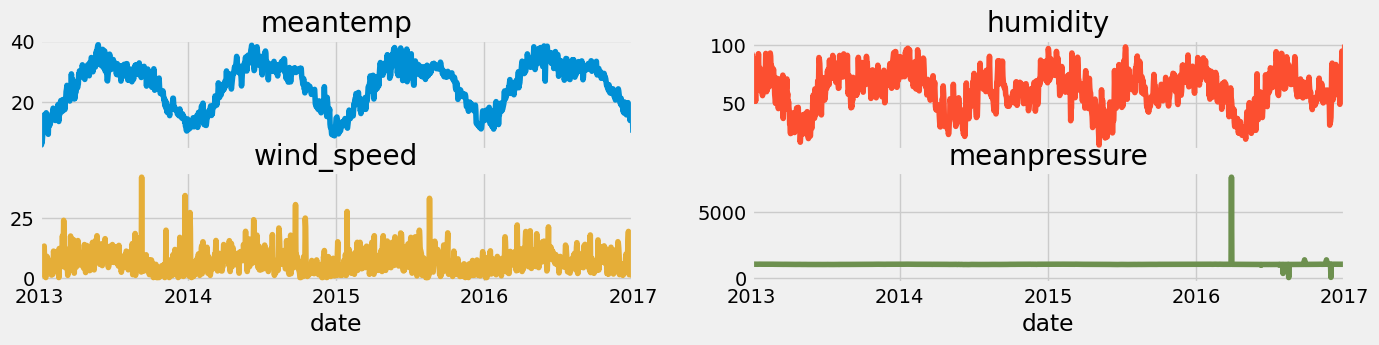

In [ ]:
axs = train.plot(subplots=True, layout=(2,2), figsize=(15,3))
for i, col in enumerate(train.columns) :
    axs[i//2][i%2].set_title(col)
    axs[i//2][i%2].get_legend().remove()
plt.show()

We can see some outliers in the *meanpressure* values.

<Figure size 640x480 with 0 Axes>

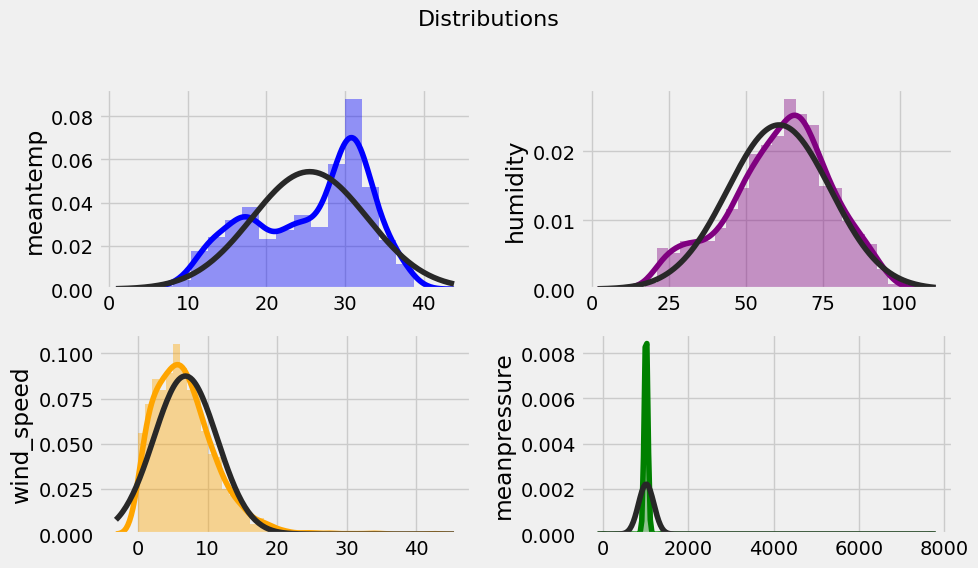

In [ ]:
colors = ["blue", "purple", "orange", "green"]
plt.figure()
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
for i, col in enumerate(train.columns):
    sns.distplot(list(train[col]), fit=norm, color=colors[i], ax=ax[i//2][i%2])
    ax[i//2][i%2].set(ylabel=f"{col}")
plt.suptitle("Distributions", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to avoid overlapping titles
plt.show()

## EDA: Handling Outliers

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor()
y_pred = clf.fit_predict(train)
scores = clf.negative_outlier_factor_
threshold = -2.5
train = train.drop(train.loc[scores < threshold].index)

In [ ]:
train.shape

(1450, 4)

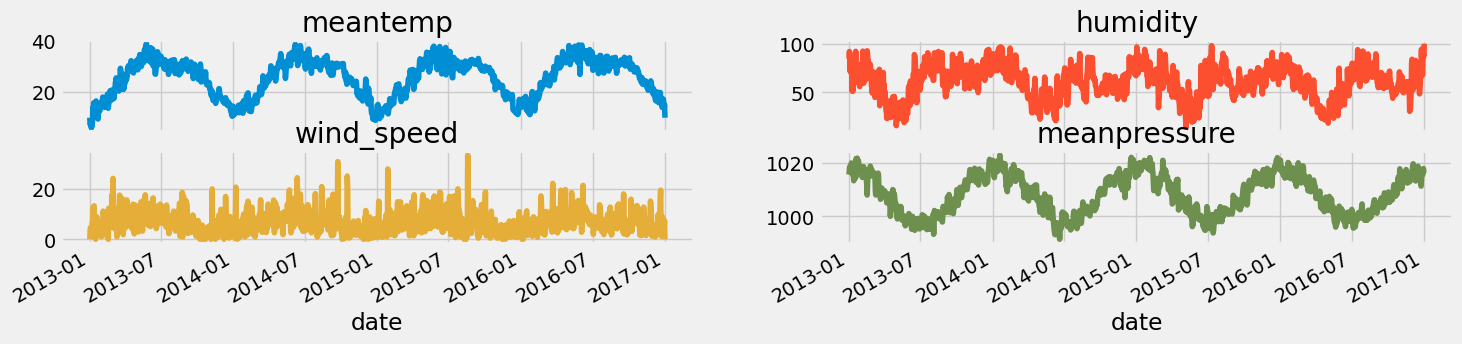

In [ ]:
axs = train.plot(subplots=True, layout=(2,2), figsize=(16,3))
for i, col in enumerate(train.columns) :
    axs[i//2][i%2].set_title(col)
    axs[i//2][i%2].get_legend().remove()
plt.show()

In [ ]:
clf_test = LocalOutlierFactor()
y_pred_test = clf_test.fit_predict(test)
scores_test = clf_test.negative_outlier_factor_
test = test.drop(test.loc[scores_test < threshold].index)

## EDA: Feature Correlation

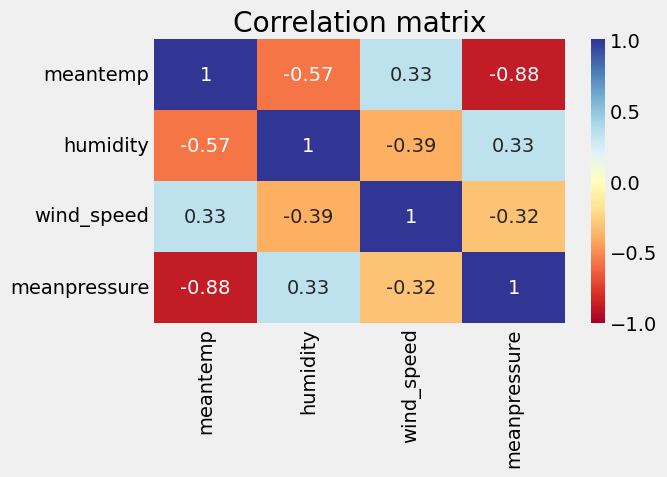

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7, 5))

corr = train.loc[:, train.columns].corr()
ax.set_title("Correlation matrix")
sns.heatmap(corr, annot=True, cmap="RdYlBu", vmin=-1, ax=ax)
plt.tight_layout()
plt.show()

## Stationarity (for both approaches)

**Definition**: Mean, Variance and Covariance are constant and time independent,

How to test for stationarity? :
**Augmented Dickey-Fuller (ADF)** statistical test

* **H0** : Time series is not stationary.
* **H1** : Time series is stationary.

We can reject **Null Hypothesis** if one the following holds:
* *p-value* <= significance level (default: 0.05)
* ADF statistic < critical value

In [ ]:
from statsmodels.tsa.stattools import adfuller

signif_level = 0.05

print('\033[1m' + '--> Training features: p-values' + '\033[0m')
for col in train.columns :
    res = adfuller(train[col].values)
    p_value = res[1]
    if p_value<=signif_level:
      stat = '(i.e. stationary feature)'
    else:
      stat = '(i.e. non stationary feature)'
    print(col+ f': {res[1]} ' + stat)

#alternatively use res[0] for the ADF statistic value and res[4] for the critical value

--> Training features: p-values
meantemp: 0.2813930189163836 (i.e. non stationary feature)
humidity: 0.004100883389291905 (i.e. stationary feature)
wind_speed: 0.003501614538532722 (i.e. stationary feature)
meanpressure: 0.2310614722807185 (i.e. non stationary feature)


What about the **test features**?

Converting a non stationary feature into a stationary feature is transformation (like scaling). Thus, when testing we will apply the transformation to those features that were transformed for training as well.

In practise this is translated as follows in the code:

*   ARIMA: For prediction we directly ask the model to forecast a desired number of time steps. Then we apply reverse differencing to those features that were also transformed to stationary during training. This scales the values to the real test feature values and as a result comparison makes sense.
*   LSTM: In this case we pass to the model a test sequence (x_test) which is transformed to stationary in those features that were transformed during training as well. After the prediction we revert the differencing.



**Differencing** : Technique for transforming series into stationarity series.

We apply differencing to the 'meantemp' and 'meanpressure' features. The dataframe with the stationary features is called df_stat.

In [ ]:
df_stat = train.copy()
df_stat["meantemp"] = train["meantemp"].diff(periods = 1); df_stat["meantemp"].iloc[0] = 0
df_stat["meanpressure"] = train["meanpressure"].diff(periods = 1); df_stat["meanpressure"].iloc[0] = 0

print('\033[1m' + '--> Training features: New p-values' + '\033[0m')
for col in ['meantemp', 'meanpressure']:
    res = adfuller(df_stat[col].values)
    p_value = res[1]
    if p_value<=signif_level:
      stat = '(i.e. stationary feature)'
    else:
      stat = '(i.e. non stationary feature)'
    print(col+ f': {res[1]} ' + stat)

--> Training features: New p-values
meantemp: 3.479420436055356e-29 (i.e. stationary feature)
meanpressure: 1.5176181765124312e-29 (i.e. stationary feature)


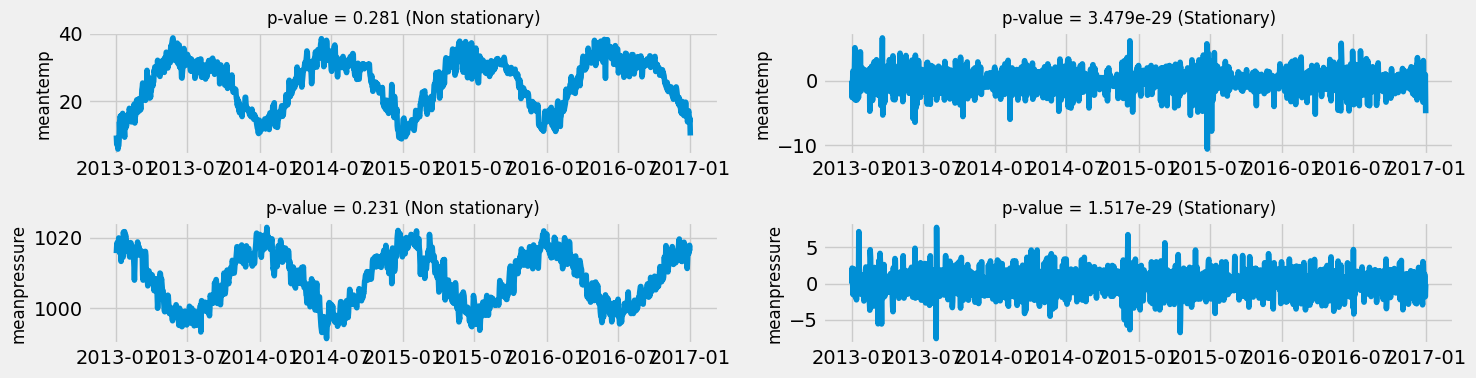

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15, 4))

ax[0,0].plot(train.index, train['meantemp'].values); ax[0,0].set_title('p-value = 0.281 (Non stationary)', fontsize=12); ax[0,0].set_ylabel(ylabel='meantemp', fontsize=12)
ax[0,1].plot(df_stat.index, df_stat['meantemp'].values); ax[0,1].set_title('p-value = 3.479e-29 (Stationary)', fontsize=12); ax[0,1].set_ylabel(ylabel='meantemp', fontsize=12)
ax[1,0].plot(train.index, train['meanpressure'].values); ax[1,0].set_title('p-value = 0.231 (Non stationary)', fontsize=12); ax[1,0].set_ylabel(ylabel='meanpressure', fontsize=12)
ax[1,1].plot(df_stat.index, df_stat['meanpressure'].values); ax[1,1].set_title('p-value = 1.517e-29 (Stationary)', fontsize=12); ax[1,1].set_ylabel(ylabel='meanpressure', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# to be used later for predictions

def reverse_differencing(predictions, last_value):

    # function that performs cumulative summation to reverse the differencing
    # 'predictions' are the predicted values in the stationary domain
    # 'last_value' is the last value of the original non-stationary feature

    original_predictions = np.cumsum(predictions) + last_value

    return original_predictions

## ARIMA models

The Auto-Regressive Integrated Moving Average (ARIMA) model describes the autocorrelations in the data.<br/> The model assumes that the time-series is stationary.

In [ ]:
!pip install pmdarima

In [ ]:
# need to !pip install pmdarima
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

def arima_train_test_data(df_stat, feature):

    feature_col = list(df_stat.columns).index(feature)
    x_train = df_stat.iloc[:,feature_col].values
    x_test = test.iloc[:,feature_col].values

    return x_train, x_test

def arima_optimal_model(x_train):

    model = pm.auto_arima(x_train, test='adf', seasonal=False, return_valid_fits=False, suppress_warnings=True)

    return model

def arima_train_and_test(x_train, x_test, order, stationary = False):

    # stationary: Boolean that says if the training feature was stationary or not

    #train
    model = ARIMA(x_train, order=order)
    model_fit = model.fit()

    #predict
    x_pred = model_fit.forecast(x_test.shape[0])
    if stationary == True:
        x_pred = reverse_differencing(x_pred, x_test[0]) #undo differencing

    #metrics
    score_mae = mean_absolute_error(x_test, x_pred)
    score_rmse = np.sqrt(mean_squared_error(x_test, x_pred))

    return x_pred, score_mae, score_rmse

In [ ]:
for feature in df_stat.columns:
    print('Feature: {}'.format(feature))
    x_train, _ = arima_train_test_data(df_stat, feature)
    print('optimal model: {}'.format(arima_optimal_model(x_train)))

Feature: meantemp
optimal model:  ARIMA(1,0,1)(0,0,0)[0]          
Feature: humidity
optimal model:  ARIMA(1,0,4)(0,0,0)[0] intercept
Feature: wind_speed
optimal model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Feature: meanpressure
optimal model:  ARIMA(1,0,2)(0,0,0)[0]          


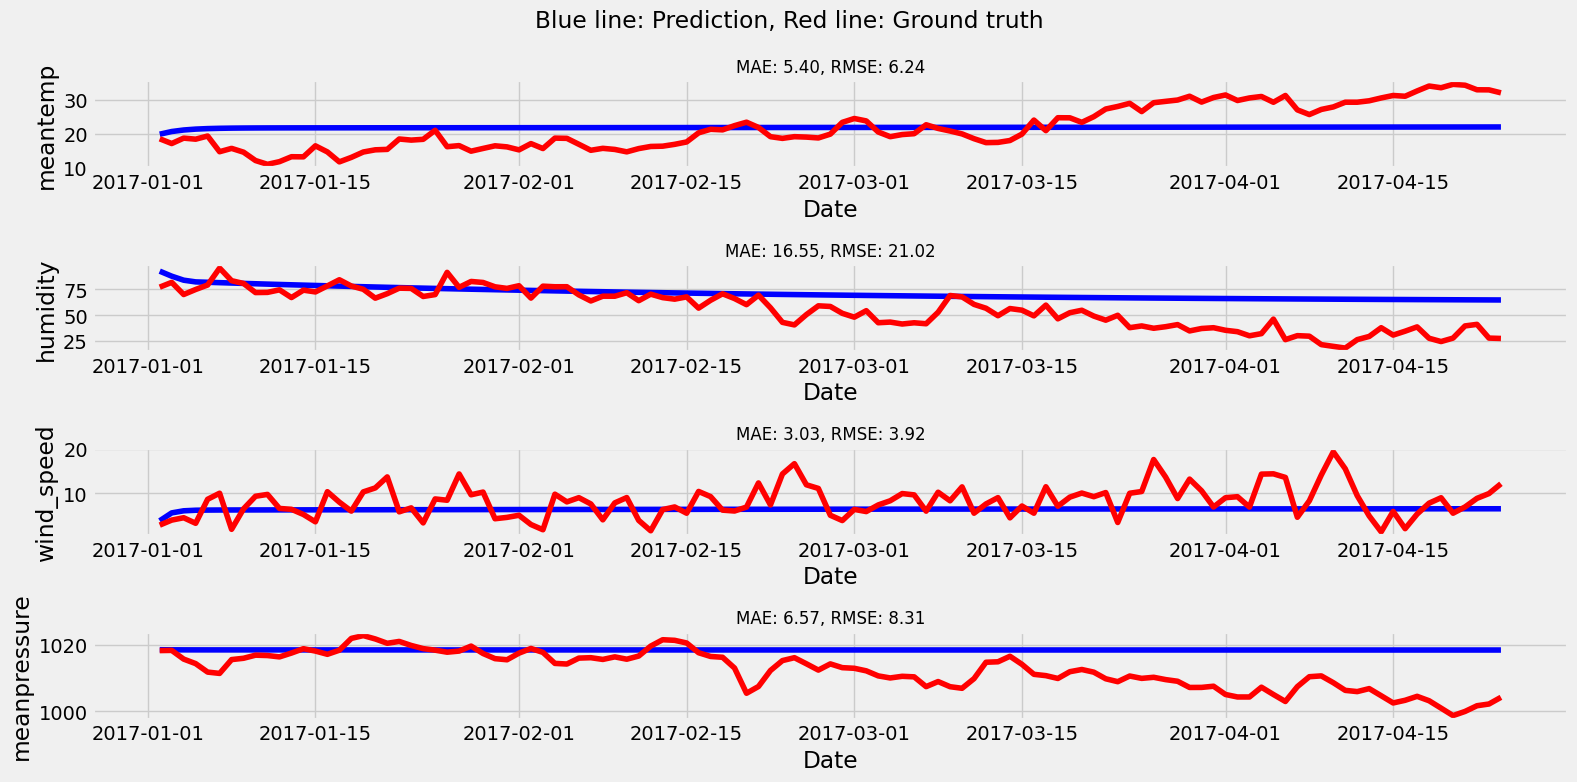

In [ ]:
fig, ax = plt.subplots(4,1, figsize=(16, 8))
orders = [(1,0,1), (1,0,4), (2,0,2), (1,0,2)]

for i, feature in enumerate(df_stat.columns):

    x_train, x_test = arima_train_test_data(df_stat, feature)

    if feature in ['humidity', 'wind_speed']:
        x_pred, score_mae, score_rmse = arima_train_and_test(x_train, x_test, orders[i], False)
    else:
        x_pred, score_mae, score_rmse = arima_train_and_test(x_train, x_test, orders[i], True)

    ax[i].plot(test.index, x_pred, color='blue') #Prediction
    ax[i].plot(test.index, x_test, color='red') #Ground truth

    ax[i].set_title(f'MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=12)
    ax[i].set_xlabel(xlabel='Date')
    ax[i].set_ylabel(ylabel=feature)

fig.suptitle('Blue line: Prediction, Red line: Ground truth')
plt.tight_layout()
plt.show()

## Feature Engineering (for the LSTM model)

In [ ]:
def add_date_features(dataframe):

  # 6 additional features

  dataframe = dataframe.copy()

  dataframe['day_of_year'] = dataframe.index.dayofyear
  dataframe['week_of_year'] = dataframe.index.weekofyear
  dataframe['quarter'] = dataframe.index.quarter
  dataframe['season'] = dataframe.index.month % 12 // 3 + 1

  months = 12
  dataframe['month_sin'] = np.sin(2*np.pi*dataframe.index.month/months)
  dataframe['month_cos'] = np.cos(2*np.pi*dataframe.index.month/months)

  return dataframe

In [ ]:
# Trend : The increasing or decreasing value in the series.
# Seasonality : The repeating short-term cycle in the series.

from statsmodels.tsa.seasonal import seasonal_decompose

def add_trend_seasonality_features(dataframe, period):

    # 8 additional features

    dataframe = dataframe.copy()
    for i, col in enumerate(dataframe.columns[:4]):

        res = seasonal_decompose(dataframe[col], period=period, extrapolate_trend='freq')
        dataframe[f"{col}_trend"] = res.trend
        dataframe[f"{col}_seasonal"] = res.seasonal

    return dataframe

**Dataframes**

In [ ]:
# training dataframes

print(df_stat.shape) #stationary version of the training data

df_date_features = add_date_features(df_stat)
print(df_date_features.shape)

df_trend_seasonality_features = add_trend_seasonality_features(df_stat, 365)
print(df_trend_seasonality_features.shape)

df_all_features = add_trend_seasonality_features(df_date_features, 365)
print(df_all_features.shape)

(1450, 4)
(1450, 10)
(1450, 12)
(1450, 18)


In [ ]:
# test dataframes

df_test = test.iloc[:-1,:].copy()

# differencing the same features as in the training
df_test["meantemp"] = test["meantemp"].diff(periods = 1); df_test["meantemp"].iloc[0] = 0
df_test["meanpressure"] = test["meanpressure"].diff(periods = 1); df_test["meanpressure"].iloc[0] = 0

# features
print(df_test.shape) #stationary version of the test data

df_date_features_test = add_date_features(df_test)
print(df_date_features_test.shape)

df_trend_seasonality_features_test = add_trend_seasonality_features(df_test, 1)
# we note that there is essentially no seasonality because we only have 112 days while the model was trained over yearly data.. thus eliminate seasonality by setting period = 1
print(df_trend_seasonality_features_test.shape)

df_all_features_test = add_trend_seasonality_features(df_date_features_test, 1)
print(df_all_features_test.shape)

(112, 4)
(112, 10)
(112, 12)
(112, 18)


## LSTM model (multifeature)

*   We note that fitting the model only with the 4 original features yields ***underfitting*** models of various complexities. We address this issue by **increasing the number of features in the dataset**; considering date, trend and seasonality features.
*   We train **3 models**: one model with additional date features, one with additional trend & seasonality features and one with both date and trend & seasonality features.
*   We **train/validate/test** all models as follows: train on 2013,2014 and 2015 data, validate on 2016 data (and also further train on them upon model selection) and test on 2017 data.
*   ***TO DO*** : **Fine tuning** the models' architecture and training hyperparamaters. We note that the current models despite they are not fine tuned, they still serve the ARIMA comparison purposes.


In [ ]:
# lstm.py custom written code
from lstm import lstm_train_val_data, model

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def model_predict(model, scaler, test_dataframe):

    #normalization
    normed = scaler.transform(test_dataframe)

    #prediction
    normed = np.reshape(normed, (normed.shape[0], 1, normed.shape[1]))
    x_pred = model.predict(normed)

    #un-normalization
    unnormed = scaler.inverse_transform(x_pred)

    #un-differencing
    preds = unnormed.copy()
    preds[:,0] = reverse_differencing(preds[:,0], test['meantemp'][0])
    preds[:,3] = reverse_differencing(preds[:,3], test['meanpressure'][0])

    return preds

In [ ]:
train_dataframes = [df_date_features, df_trend_seasonality_features, df_all_features]
test_dataframes = [df_date_features_test, df_trend_seasonality_features_test, df_all_features_test]
features = ['Date features', 'Trend & Seasonality features', 'All features']

y_test = test.iloc[:-1,:].copy().values

rmse, mae = [], []

for traindf, testdf, feature in zip(train_dataframes, test_dataframes, features):

    print('\n', '-->', feature)
    x_train, y_train, x_val, y_val, scaler = lstm_train_val_data(traindf)
    lstm_model = model(x_train, y_train, x_val, y_val).fit()
    lstm_model.fit(x_val, y_val, batch_size=32, epochs=10, verbose=0)
    preds = model_predict(lstm_model, scaler, testdf)

    print('\n', 'Test metrics')
    for i, col in enumerate(['meantemp','humidity','wind_speed','meanpressure']):
        score_rmse = np.sqrt(mean_squared_error(y_test[:,i], preds[:,i]))
        rmse.append(score_rmse)
        score_mae = mean_absolute_error(y_test[:,i], preds[:,i])
        mae.append(score_mae)
        print(col, '  MSE:', score_mae, '  RMSE:', score_rmse)


 --> Date features
Epoch 1/10
9/9 [==============================] - 10s 243ms/step - loss: 0.3404 - val_loss: 0.3222
Epoch 2/10
9/9 [==============================] - 0s 40ms/step - loss: 0.3171 - val_loss: 0.3120
Epoch 3/10
9/9 [==============================] - 0s 34ms/step - loss: 0.3112 - val_loss: 0.3092
Epoch 4/10
9/9 [==============================] - 0s 35ms/step - loss: 0.3095 - val_loss: 0.3080
Epoch 5/10
9/9 [==============================] - 1s 59ms/step - loss: 0.3096 - val_loss: 0.3080
Epoch 6/10
9/9 [==============================] - 0s 52ms/step - loss: 0.3093 - val_loss: 0.3085
Epoch 7/10
9/9 [==============================] - 0s 49ms/step - loss: 0.3092 - val_loss: 0.3082
Epoch 8/10
9/9 [==============================] - 1s 56ms/step - loss: 0.3092 - val_loss: 0.3082
Epoch 9/10
9/9 [==============================] - 0s 55ms/step - loss: 0.3092 - val_loss: 0.3079
Epoch 10/10
4/4 [==============================] - 2s 6ms/step

 Test metrics
meantemp   MSE: 4.685551615

We choose the model equipped with the trend and seasonality features among the three. Below we plot the test performance.

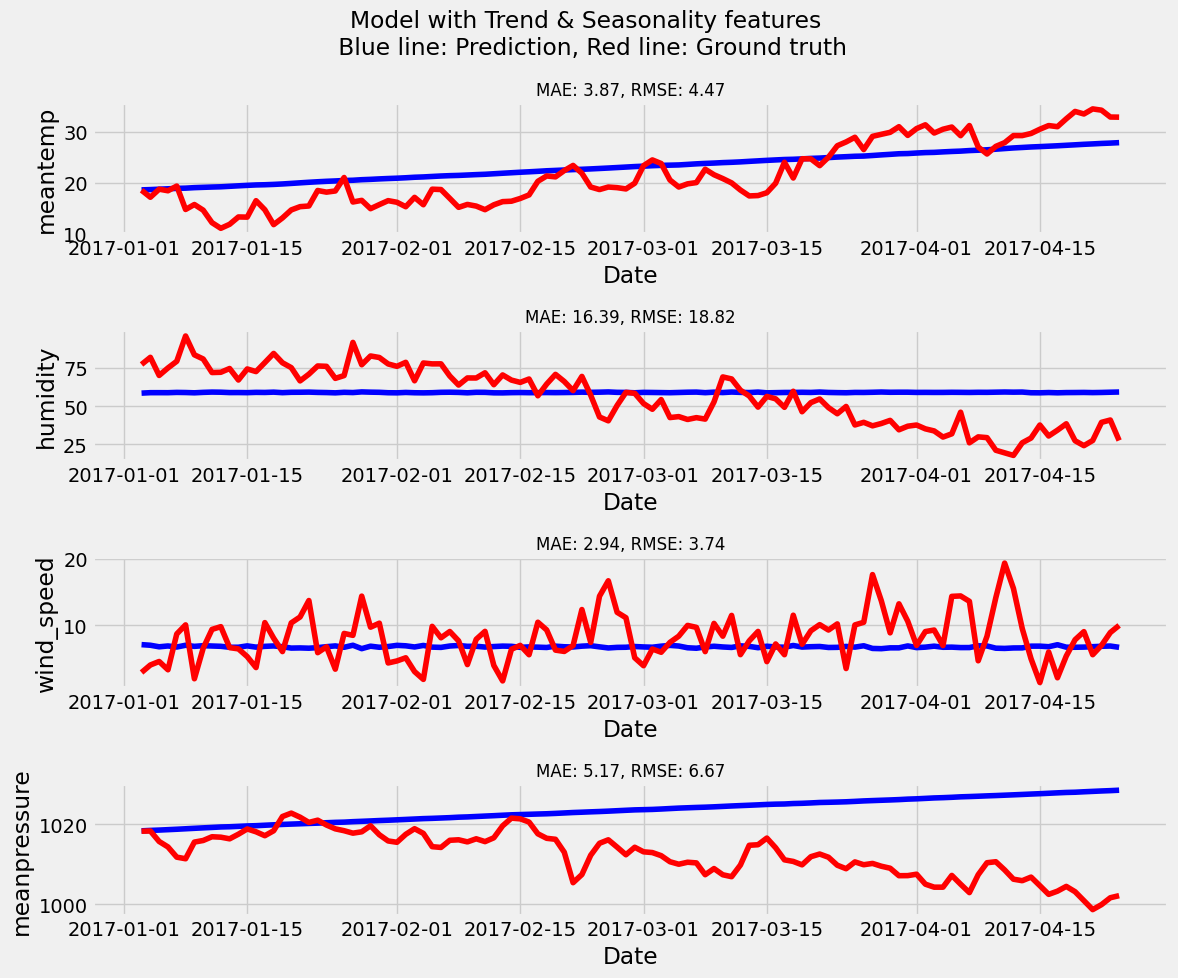

In [ ]:
fig, ax = plt.subplots(nrows=len(test.columns), figsize=(12, 10))

for i, feature in enumerate(test.columns):

    ax[i].plot(test.index[1:], preds[:,i], color='blue') #Prediction
    ax[i].plot(test.index[1:], y_test[:,i], color='red') #Ground truth

    ax[i].set_title(f'MAE: {mae[4+i]:.2f}, RMSE: {rmse[4+i]:.2f}', fontsize=12)
    ax[i].set_xlabel(xlabel='Date')
    ax[i].set_ylabel(ylabel=feature)

fig.suptitle('Model with Trend & Seasonality features \n Blue line: Prediction, Red line: Ground truth')
plt.tight_layout()
plt.show()